In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional, LayerNormalization, SpatialDropout1D, GRU, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix, classification_report
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import time
import shap
import random

nltk.download('wordnet')
nltk.download('stopwords')

# Load dataset. CHANGE file_path!
file_path = "/content/drive/My Drive/bbc_text.csv"
df = pd.read_csv(file_path)

# Create category_id column
df['category_id'] = df.category.factorize()[0]

# Sanitize dataset to remove invalid or non-finite values
df = df[df['category_id'].notnull()]  # Remove rows with NaN values
df = df[~np.isinf(df['category_id'])]  # Remove rows with infinite values
df = df.dropna(subset=['text', 'category_id'])
df['category_id'] = df['category_id'].astype(int)  # Ensure category_id is an integer

# Create category ID DataFrame
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values(by='category_id').reset_index(drop=True)
df.head()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,category,text,category_id
0,tech,tv future in the hands of viewers with home th...,0
1,business,worldcom boss left books alone former worldc...,1
2,sport,tigers wary of farrell gamble leicester say ...,2
3,sport,yeading face newcastle in fa cup premiership s...,2
4,entertainment,ocean s twelve raids box office ocean s twelve...,3


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1DTqO1F0wMMcjBQh50iewQTNNMfue2_rDV-DXcxCSHZo#gid=0


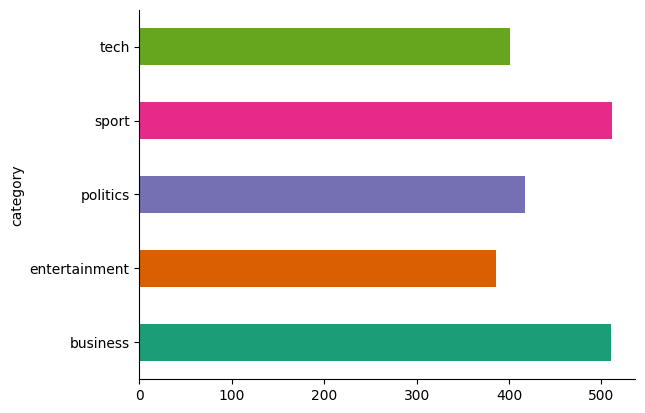

In [3]:
# @title category

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer

# Tokenization and Vectorization with unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=5000)  # Includes unigrams and bigrams
X_vectorized = vectorizer.fit_transform(df['text'])

# Chi-Squared Feature Selection
chi2_scores, p_values = chi2(X_vectorized, df['category_id'])
feature_names = vectorizer.get_feature_names_out()
chi2_df = pd.DataFrame({'Feature': feature_names, 'Chi2_Score': chi2_scores, 'P_Value': p_values})
important_features = chi2_df.nlargest(1500, 'Chi2_Score')['Feature'].tolist()


# Create a dictionary to store top features for each category
top_features = {}

# Iterate over each category
for category_id in df['category_id'].unique():
    # Subset data for the current category
    mask = (df['category_id'] == category_id)

    # Perform Chi-Squared test on this subset
    chi2_scores, _ = chi2(X_vectorized, mask)

    # Get the top 2 unigrams/bigrams for the category
    top_indices = np.argsort(chi2_scores)[::-1][:2]
    top_features[category_id] = [feature_names[i] for i in top_indices]

# Map category IDs back to category names
category_names = {row['category_id']: row['category'] for _, row in category_id_df.iterrows()}
top_features_named = {category_names[cat_id]: features for cat_id, features in top_features.items()}

print("Top Features for Each Category:")
for category, features in top_features_named.items():
    print(f"{category}: {features}")

Top Features for Each Category:
tech: ['technology', 'mobile']
business: ['oil', 'growth']
sport: ['cup', 'england']
entertainment: ['film', 'best']
politics: ['labour', 'mr']


In [5]:
# Define function
def prioritize_features(text, top_features_named):
    for category, featrures in top_features_named.items():
        for feature in features:
            if feature in text:
                text += f"{feature} {feature}" # boost importance by duplicating features
    return text

# Apply feature prioritization
df['text'] = df['text'].apply(lambda x: prioritize_features(x, top_features_named))

# Synonym Replacement Data Augmentation
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


def synonym_replacement(text, important_words):
    words = text.split()
    augmented_text = []
    for word in words:
        if word in important_words:  # Only replace high-impact words
            synonyms = wordnet.synsets(word)
            if synonyms:
                synonym = synonyms[0].lemmas()[0].name()
                augmented_text.append(synonym if synonym != word else word)
            else:
                augmented_text.append(word)
        else:
            augmented_text.append(word)
    return ' '.join(augmented_text)

# Apply only to tech & business categories
df['text'] = df.apply(lambda row: synonym_replacement(row['text'], important_features)
                      if row['category'] in ['tech', 'business'] else row['text'], axis=1)


# Function for paraphrasing using random word drop
def paraphrase(text, drop_prob=0.2):
    words = text.split()
    return ' '.join([word for word in words if random.random() > drop_prob])

important_words = important_features

# Apply synonym replacement to underperforming classes
def augment_data(df, target_classes):
    augmented_texts = []
    for _, row in df.iterrows():
        if row['category'] in target_classes:
            augmented_texts.append(synonym_replacement(row['text'], important_words))
            augmented_texts.append(paraphrase(row['text']))
    return augmented_texts

underperforming_classes = ['business', 'entertainment']
augmented_texts = augment_data(df[df['category'].isin(underperforming_classes)], underperforming_classes)


# Validate target variable
y = df['category_id'].astype(int)
if y.isnull().any():
    raise ValueError("Target variable contains null values.")
    df = df.dropna(subset=['category_id'])

df_augmented = pd.DataFrame({
    'text': augmented_texts,
    'category': underperforming_classes * (len(augmented_texts) // len(underperforming_classes))
})

# Reverse the `category_names` dictionary for mapping
reversed_category_names = {v: k for k, v in category_names.items()}
df_augmented['category_id'] = df_augmented['category'].map(reversed_category_names)


df_augmented = pd.DataFrame({'text': augmented_texts, 'category': underperforming_classes * (len(augmented_texts) // len(underperforming_classes))})
df = pd.concat([df, df_augmented], ignore_index=True)

# Check for null values and remove them
df = df.dropna(subset=['text', 'category_id'])

# Reassign target variable
y = df['category_id'].values

# Tokenization and sequence padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
X = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X, maxlen=500)  # Adjust maxlen if needed

# Verify data consistency
assert len(X) == len(y), "Mismatch in data sizes after preprocessing!"

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
from nltk.corpus import stopwords
import re

# Download stopwords if not available
nltk.download('stopwords')

# Load default stopwords & add custom dataset-specific words
custom_stopwords = set(stopwords.words('english'))
custom_stopwords.update(["mr", "mrmr", "people", "want", "us", "one", "said", "also", "new", "s", "like", "many"])

# Function to clean text
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ' '.join([word for word in text.split() if word.lower() not in custom_stopwords])  # Remove stopwords
    return text

# Apply cleaning
df['text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Functions for printing the Accuracy and Loss graphs, as well a the confusion matrix
# function for plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Plot accuracy
def plot_acc_loss(modelToUse, modelName = "Model"):
    plt.plot(modelToUse.history['accuracy'], label='Train Accuracy')
    plt.plot(modelToUse.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('{} Accuracy'.format(modelName))
    plt.show()

    # Loss plot
    plt.plot(modelToUse.history['loss'], label='Train Loss')
    plt.plot(modelToUse.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('{} Loss'.format(modelName))
    plt.show()

def plot_conf_matrix(modelToUse, modelName = "Model"):
    # Confusion Matrix
    matrix_y_pred = np.argmax(modelToUse.predict(X_test), axis=1)
    curr_conf_matrix = confusion_matrix(y_test, matrix_y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(curr_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_id_df['category'], yticklabels=category_id_df['category'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('{} Confusion Matrix'.format(modelName))
    plt.show()

    # Classification Report
    print(classification_report(y_test, matrix_y_pred, target_names=category_id_df['category']))


def plot_prec_recall(modelToUse, y_value, x_test, modelName = "Model"):
    # precision recall curve
    precision = dict()
    recall = dict()

    # Determine the number of unique classes
    n_classes = len(np.unique(y_value))  # y_test contains the class labels
    # Binarize the output - this creates a multi-label indicator array
    y_test_bin = label_binarize(y_value, classes=range(n_classes))
    # Assuming y_score contains the predicted probabilities for each class
    y_score = modelToUse.predict(x_test)

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i],
                                                            y_score[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
        #plt.plot(recall[i], precision[i], lw=2, label=category_id_df['category'])

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve for {}".format(modelName))
    plt.show()

def plot_tsne(modelToUse, test_data, modelName = "Model"):
    X_valid_compressed = modelToUse.predict(test_data)
    tsne = TSNE(n_components=2, random_state=42)
    X_valid_2D = tsne.fit_transform(X_valid_compressed)

    plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_test, cmap="tab10")
    plt.axis("off")
    plt.title('t-SNE visualization for {}'.format(modelName))
    plt.colorbar()
    plt.show()

In [8]:
# Build the enhanced RNN model
RNN_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, input_length=500),  # High embedding dimension
    Bidirectional(SimpleRNN(128, return_sequences=True, dropout=0.4)),  # Bidirectional RNN with dropout
    GlobalMaxPooling1D(),  # Max pooling for dimensionality reduction
    LayerNormalization(),  # Layer normalization
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Fully connected layer
    Dropout(0.5),  # Dropout for regularization
    Dense(len(category_id_df), activation='softmax')  # Output layer for category classification
])

# Compile the model
RNN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Learning rate of 0.001
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Callbacks
RNN_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
RNN_lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)


start_time = time.process_time()  # Record start time

# Train the model
RNN_history = RNN_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,  # Adjust epochs based on overfitting behavior
    batch_size=32,  # Smaller batch size for improved gradient computation
    callbacks=[RNN_early_stopping, RNN_lr_scheduler]
)

end_time = time.process_time()  # Record end time

# Evaluate the model
RNN_loss, RNN_accuracy = RNN_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {RNN_accuracy}")
print(f"Process Time: {end_time - start_time}")  # Calculate and print the difference

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 899ms/step - accuracy: 0.2503 - loss: 3.4987 - val_accuracy: 0.5124 - val_loss: 2.4054 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 782ms/step - accuracy: 0.4701 - loss: 2.3920 - val_accuracy: 0.5303 - val_loss: 2.0274 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 798ms/step - accuracy: 0.5268 - loss: 1.9934 - val_accuracy: 0.5775 - val_loss: 1.7207 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 789ms/step - accuracy: 0.6329 - loss: 1.6307 - val_accuracy: 0.6562 - val_loss: 1.3814 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 765ms/step - accuracy: 0.6933 - loss: 1.4168 - val_accuracy: 0.7124 - val_loss: 1.2213 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 770ms/step - accuracy: 0.8033 - loss: 1.0239 - val_accuracy: 0.8135 - val_loss: 0.9215 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 759ms/step - accuracy: 0.8536 - loss: 0.7915 - val_

In [ ]:
!pip install lime
from lime.lime_text import LimeTextExplainer

# Initialize LIME explainer
lime_explainer = LimeTextExplainer(class_names=category_id_df['category'].tolist())

# Select a sample text for explanation
text_sample = df['text'].iloc[0]

# Define prediction function
def predict_proba(texts):
    seq = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(seq, maxlen=500)
    return RNN_model.predict(padded)

# Explain single prediction
lime_exp = lime_explainer.explain_instance(text_sample, predict_proba, num_features=10)

# Show explanation
lime_exp.show_in_notebook()

157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step


Understanding the LIME Output
LIME is highlighting words in the text that contributed the most to the model’s classification decision. The explanation consists of:

Prediction Probabilities

The model classified the text as "tech" with 88% probability.
Other categories had significantly lower probabilities:
Business: 8%
Sport: 0%
Entertainment: 0%
Politics: 4%
This suggests a strong confidence in the "tech" classification.
Words That Influenced the Decision

LIME identifies the most important words that pushed the classification towards "tech."
The words with highest impact on classification include:
"people" (0.36) – Highly influential
"mr" (0.17) – Moderate influence
"tv" (0.12) – Important keyword for "tech"
"high" (0.04) – Likely contributing due to context with "high-definition" in tech
"us" (0.03), "play" (0.03), "want" (0.02) – Lower influence but still relevant
Text with Highlighted Words

The full text was analyzed, and LIME highlighted words in it that influenced the decision.
Words like "tv", "high-definition", "broadband", and "digital video recorders" are crucial indicators of technology-related content.
Some generic words ("mr", "people", "want") have a small effect, possibly due to dataset bias.


Identified top features into the training process, prioritize them in the dataset, and refine the RNN model training.

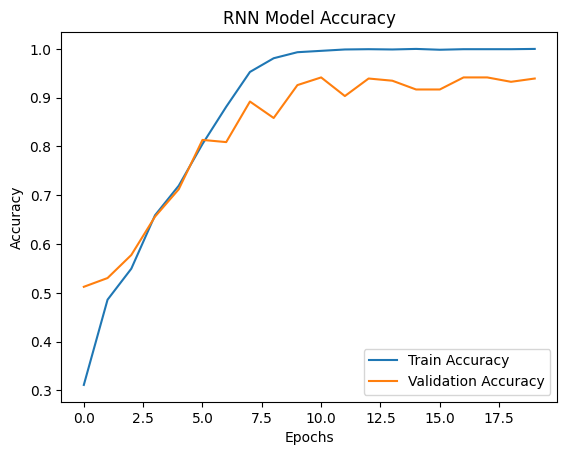

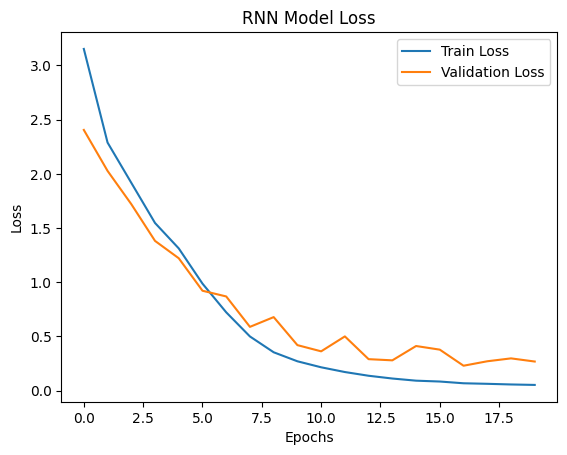

In [28]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(RNN_history.history['accuracy'], label='Train Accuracy')
plt.plot(RNN_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('RNN Model Accuracy')
plt.show()

# Loss plot
plt.plot(RNN_history.history['loss'], label='Train Loss')
plt.plot(RNN_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Model Loss')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step


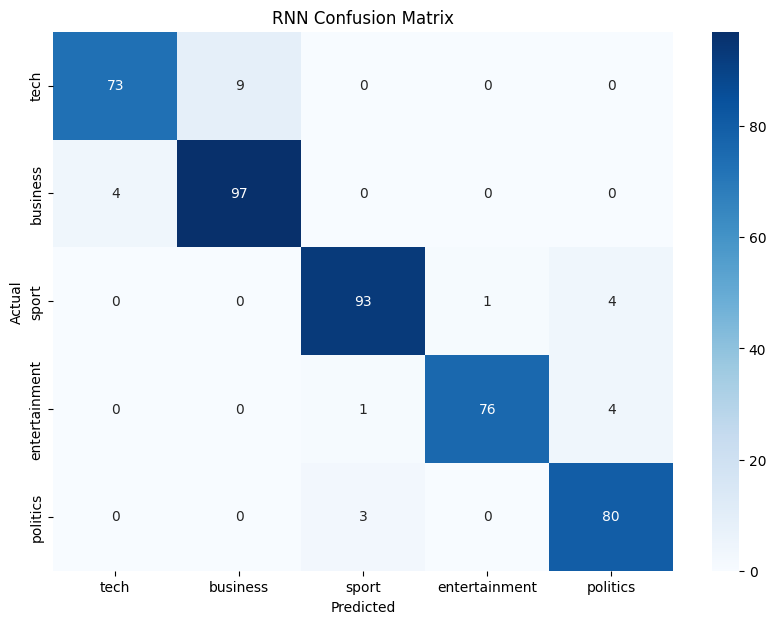

               precision    recall  f1-score   support

         tech       0.95      0.89      0.92        82
     business       0.92      0.96      0.94       101
        sport       0.96      0.95      0.95        98
entertainment       0.99      0.94      0.96        81
     politics       0.91      0.96      0.94        83

     accuracy                           0.94       445
    macro avg       0.94      0.94      0.94       445
 weighted avg       0.94      0.94      0.94       445



In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion Matrix
y_pred_rnn = np.argmax(RNN_model.predict(X_test), axis=1)
conf_matrix_rnn = confusion_matrix(y_test, y_pred_rnn)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=category_id_df['category'], yticklabels=category_id_df['category'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RNN Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_rnn, target_names=category_id_df['category']))


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step


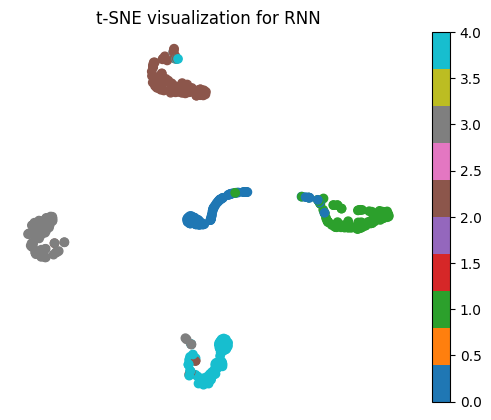

In [30]:
plot_tsne(RNN_model, X_test, "RNN")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


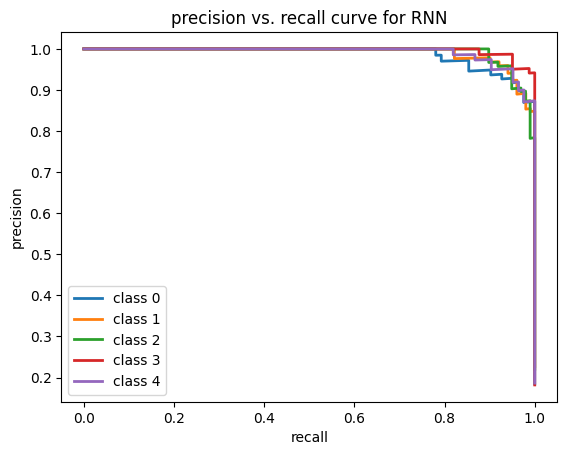

In [31]:
plot_prec_recall(RNN_model, y_test, X_test, "RNN")

# GRU Section

In [11]:
GRU_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, input_length=500),
    GRU(64, return_sequences=True),                                                        # been tweaking around 64
    GlobalMaxPooling1D(),
    LayerNormalization(),                                                                  # Layer normalization
    Dense(32, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),     # l2 regularizer to try and help prevent overfitting
    Dropout(0.5),
    Dense(5, activation = "softmax")    # 5 for the 5 categories
])

# Compile the model
GRU_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00075), loss='sparse_categorical_crossentropy', metrics=['accuracy']) #0.00075 for learning rate. Above this and it overfits.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

GRU_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
GRU_lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)


start_time = time.process_time()  # Record start time

# Train the model
GRU_history = GRU_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,      # original 20
    batch_size=32,  # original is 32
    callbacks=[GRU_early_stopping, GRU_lr_scheduler]
)

end_time = time.process_time()  # Record end time
print(f"Process Time: {end_time - start_time}")  # Calculate and print the difference

# Evaluate the model
GRU_loss, GRU_accuracy = GRU_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {GRU_accuracy}")

Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 830ms/step - accuracy: 0.4778 - loss: 1.6267 - val_accuracy: 0.9528 - val_loss: 0.7353 - learning_rate: 7.5000e-04
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 78s 773ms/step - accuracy: 0.8727 - loss: 0.7569 - val_accuracy: 0.9640 - val_loss: 0.4937 - learning_rate: 7.5000e-04
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 784ms/step - accuracy: 0.9609 - loss: 0.5029 - val_accuracy: 0.9820 - val_loss: 0.4013 - learning_rate: 7.5000e-04
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 782ms/step - accuracy: 0.9785 - loss: 0.4168 - val_accuracy: 0.9843 - val_loss: 0.3393 - learning_rate: 7.5000e-04
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 783ms/step - accuracy: 0.9772 - loss: 0.3546 - val_accuracy: 0.9888 - val_loss: 0.2938 - learning_rate: 7.5000e-04
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 772ms/step - accuracy: 0.9872 - loss: 0.3027 - val_accuracy: 0.9865 - val_loss: 0.2631 - learning_rate: 7.5000e-04
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 786ms/step - acc

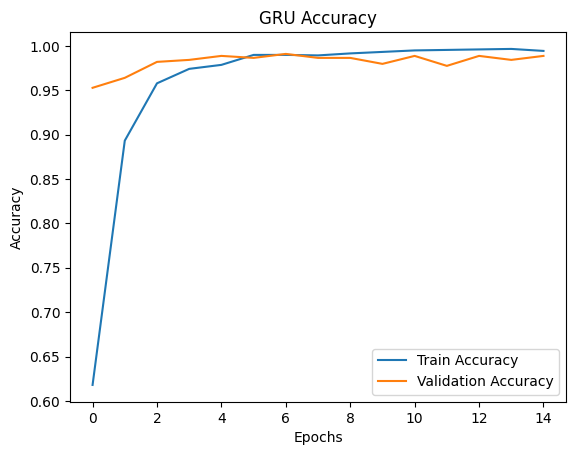

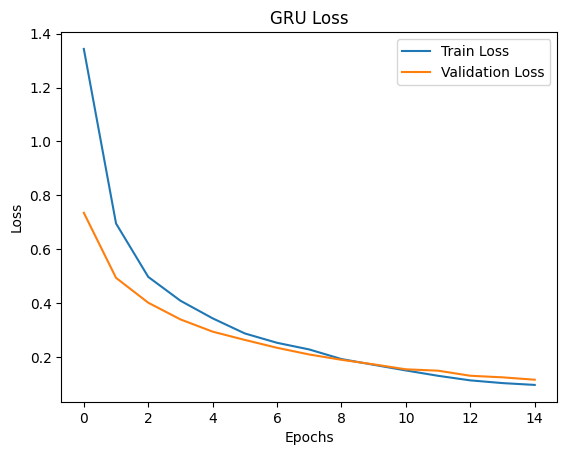

In [13]:
plot_acc_loss(GRU_history, "GRU")

In [14]:
from tensorflow.keras.models import load_model

# New real-world data
new_data = [
    "AI is transforming the tech industry.",
    "The stock market saw significant growth today.",
    "The team secured a dramatic win in the championship final.",
    "This movie is one of the best I've seen in years.",
    "The government announced new environmental policies."
]

# Preprocess new data
new_data_processed = [prioritize_features(text, top_features_named) for text in new_data]
new_sequences = tokenizer.texts_to_sequences(new_data_processed)
new_padded_sequences = pad_sequences(new_sequences, maxlen=500)

# Ensure input type matches the model requirements
new_padded_sequences = np.array(new_padded_sequences, dtype=np.int32)  # Ensure dtype compatibility

# Make predictions
try:
    new_predictions = GRU_model.predict(new_padded_sequences)
    predicted_categories = [category_id_df['category'][np.argmax(pred)] for pred in new_predictions]

    # Display predictions
    for i, text in enumerate(new_data):
        print(f"Text: {text}")
        print(f"Predicted Category: {predicted_categories[i]}")
        print("-" * 50)
except Exception as e:
    print(f"Error: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Text: AI is transforming the tech industry.
Predicted Category: entertainment
--------------------------------------------------
Text: The stock market saw significant growth today.
Predicted Category: business
--------------------------------------------------
Text: The team secured a dramatic win in the championship final.
Predicted Category: sport
--------------------------------------------------
Text: This movie is one of the best I've seen in years.
Predicted Category: entertainment
--------------------------------------------------
Text: The government announced new environmental policies.
Predicted Category: business
--------------------------------------------------


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step


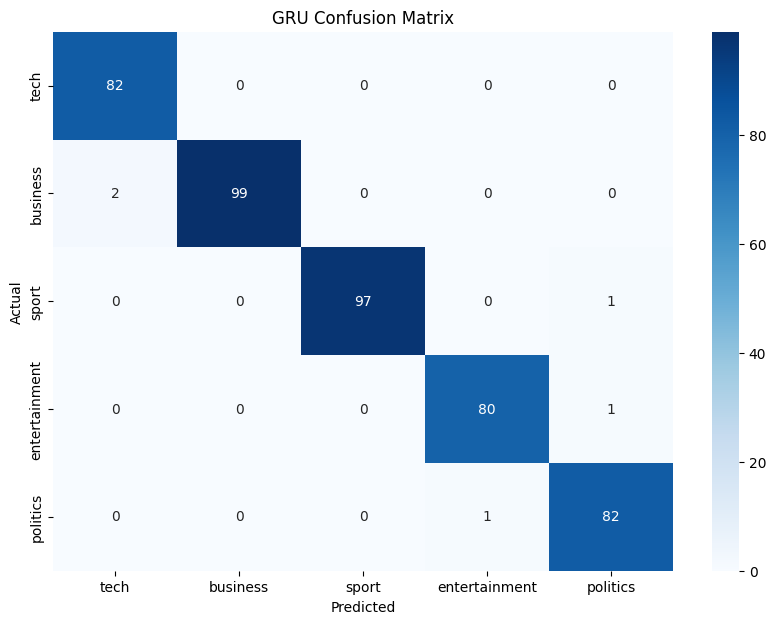

               precision    recall  f1-score   support

         tech       0.98      1.00      0.99        82
     business       1.00      0.98      0.99       101
        sport       1.00      0.99      0.99        98
entertainment       0.99      0.99      0.99        81
     politics       0.98      0.99      0.98        83

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99       445
 weighted avg       0.99      0.99      0.99       445



In [15]:
plot_conf_matrix(GRU_model, "GRU")

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step


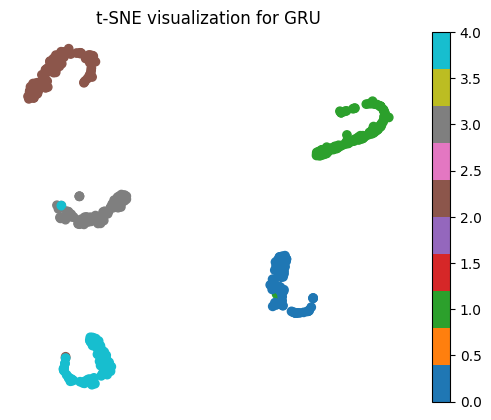

In [22]:
plot_tsne(GRU_model, X_test, "GRU")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step


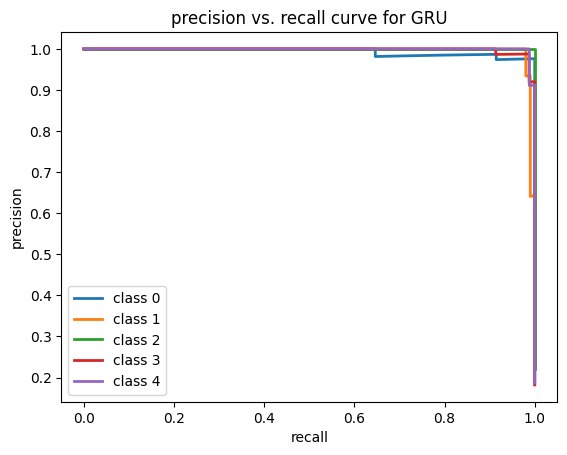

In [32]:
plot_prec_recall(GRU_model, y_test, X_test, "GRU")

# Bi-GRU

In [16]:
Bi_GRU_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, input_length=500),
    Bidirectional(GRU(64, return_sequences=True,  kernel_regularizer=tf.keras.regularizers.l2(0.01))),  # Bidirectional for understanding words around it. return_seq True for next func
    GlobalMaxPooling1D(),
    LayerNormalization(),               # Layer normalization
    Dense(32, activation = 'relu'),
    Dropout(0.5),
    Dense(5, activation = "softmax")    # 5 for the 5 categories
])

# Compile the model
Bi_GRU_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00075), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # again, LR of 0.00075

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

GRU_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
GRU_lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train the model
Bi_GRU_history = Bi_GRU_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    callbacks=[GRU_early_stopping, GRU_lr_scheduler]
)

# Evaluate the model
Bi_GRU_loss, Bi_GRU_accuracy = Bi_GRU_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {Bi_GRU_accuracy}")

Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4898 - loss: 5.0161 - val_accuracy: 0.9371 - val_loss: 2.4162 - learning_rate: 7.5000e-04
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9111 - loss: 2.1294 - val_accuracy: 0.9685 - val_loss: 1.3129 - learning_rate: 7.5000e-04
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9573 - loss: 1.1962 - val_accuracy: 0.9618 - val_loss: 0.8471 - learning_rate: 7.5000e-04
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9765 - loss: 0.7659 - val_accuracy: 0.9663 - val_loss: 0.5910 - learning_rate: 7.5000e-04
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9876 - loss: 0.5159 - val_accuracy: 0.9663 - val_loss: 0.4134 - learning_rate: 7.5000e-04
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9840 - loss: 0.3595 - val_accuracy: 0.9730 - val_loss: 0.2954 - learning_rate: 7.5000e-04
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9864 - loss:

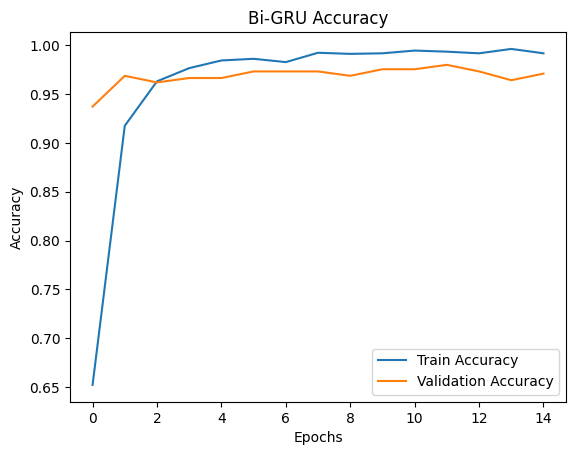

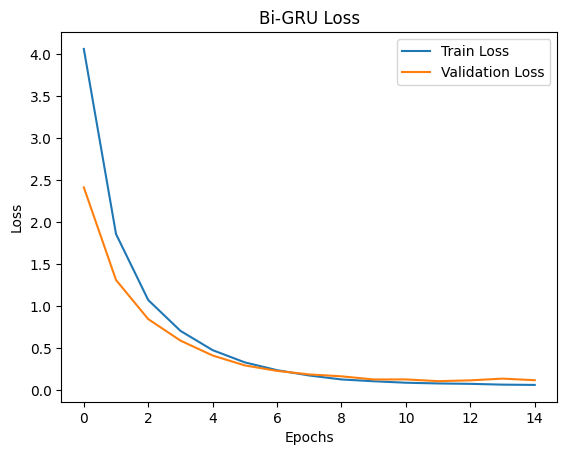

In [18]:
plot_acc_loss(Bi_GRU_history, "Bi-GRU")

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step


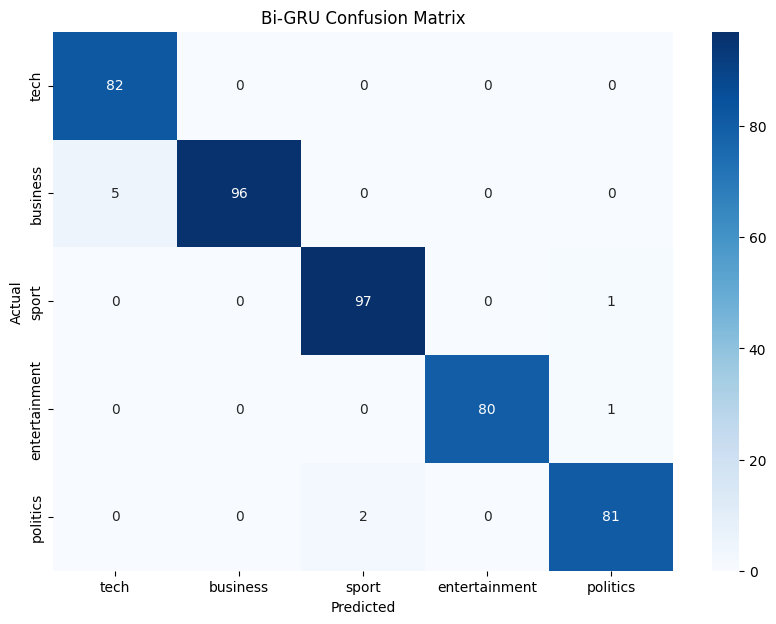

               precision    recall  f1-score   support

         tech       0.94      1.00      0.97        82
     business       1.00      0.95      0.97       101
        sport       0.98      0.99      0.98        98
entertainment       1.00      0.99      0.99        81
     politics       0.98      0.98      0.98        83

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



In [19]:
plot_conf_matrix(Bi_GRU_model, "Bi-GRU")

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step


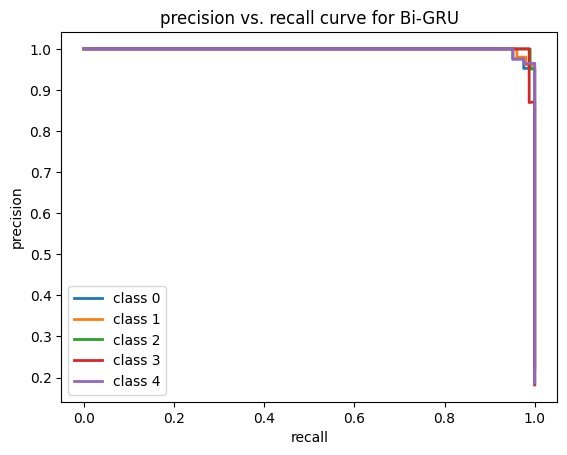

In [33]:
plot_prec_recall(Bi_GRU_model, y_test, X_test, "Bi-GRU")

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step


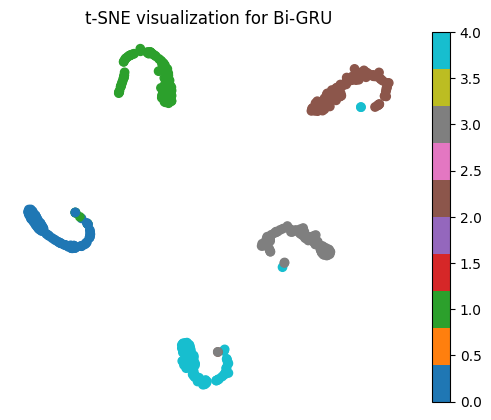

In [26]:
plot_tsne(Bi_GRU_model, X_test, "Bi-GRU")

# LSTM Section

In [20]:
# Build an LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Define model parameters
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 256  # Embedding layer size
lstm_units = 256  # LSTM units
max_len = 500  # Maximum sequence length
num_classes = len(category_id_df)  # Number of output categories

# Build the model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length = max_len),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(lstm_units, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2)),
    BatchNormalization(),
    LSTM(lstm_units // 2, dropout = 0.2, recurrent_dropout = 0.2),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation = 'softmax')
])



# Compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate=0.0001), metrics = ['accuracy'])#0.0001

# Display model summary
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 4, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, min_lr = 0.0001)


start_time = time.process_time()  # Record start time

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 30,
    batch_size = 64,
    callbacks = [early_stopping, reduce_lr]
)

end_time = time.process_time()  # Record end time
print(f"Process Time: {end_time - start_time}")  # Calculate and print the difference

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 446s 15s/step - accuracy: 0.3317 - loss: 1.5379 - val_accuracy: 0.4809 - val_loss: 1.5914 - learning_rate: 1.0000e-04
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 442s 16s/step - accuracy: 0.4538 - loss: 1.3177 - val_accuracy: 0.4966 - val_loss: 1.5699 - learning_rate: 1.0000e-04
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 495s 16s/step - accuracy: 0.4890 - loss: 1.2237 - val_accuracy: 0.5596 - val_loss: 1.5403 - learning_rate: 1.0000e-04
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 445s 16s/step - accuracy: 0.5954 - loss: 1.0176 - val_accuracy: 0.6202 - val_loss: 1.4801 - learning_rate: 1.0000e-04
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 420s 15s/step - accuracy: 0.6399 - loss: 0.7656 - val_accuracy: 0.6539 - val_loss: 1.3724 - learning_rate: 1.0000e-04
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 461s 16s/step - accuracy: 0.6783 - loss: 0.7074 - val_accuracy: 0.6539 - val_loss: 1.3035 - learning_rate: 1.0000e-04
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 450s 16s/step - accuracy: 

14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8917 - loss: 0.3081
Test Accuracy: 0.8719 Test Loss: 0.3419


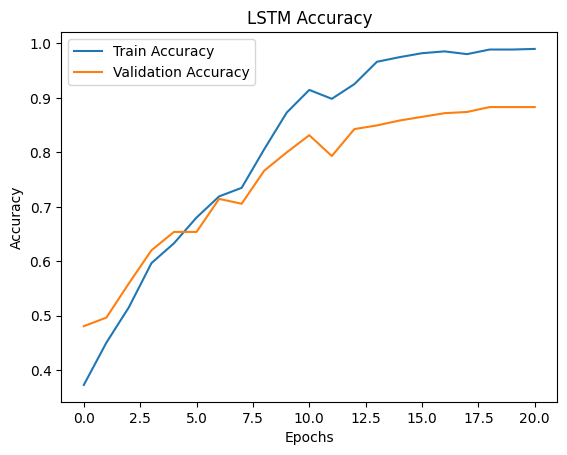

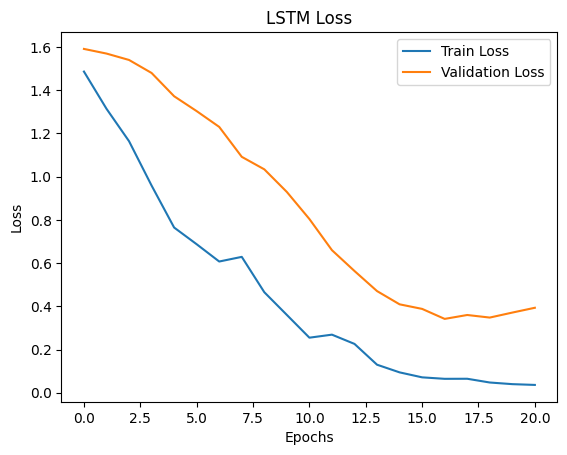

In [21]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}",f"Test Loss: {loss:.4f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM Accuracy')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Loss')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step


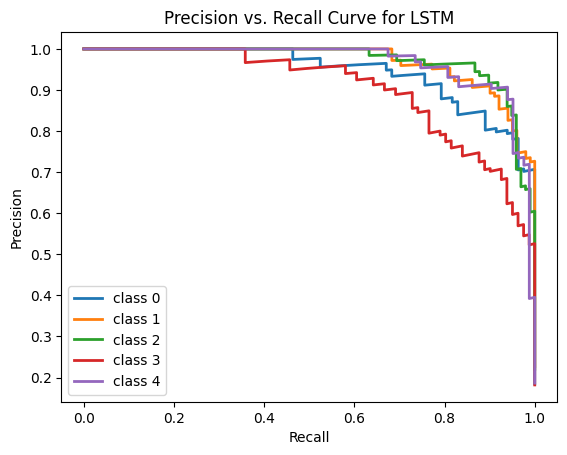

In [36]:
# precision recall curve
precision = dict()
recall = dict()

# Determine the number of unique classes
n_classes = len(np.unique(y_test))  # y_test contains the class labels
# Binarize the output - this creates a multi-label indicator array
y_test_bin = label_binarize(y_test, classes=range(n_classes))
# Assuming y_score contains the predicted probabilities for each class
y_score = model.predict(X_test)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    #plt.plot(recall[i], precision[i], lw=2, label=category_id_df['category'])

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall Curve for LSTM")
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step


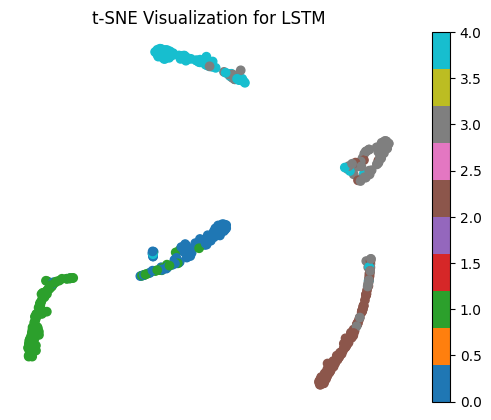

In [37]:
from sklearn.manifold import TSNE
X_valid_compressed=model.predict(X_test)
tsne = TSNE(n_components=2, random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_test, cmap="tab10")
plt.axis("off")
plt.title('t-SNE Visualization for LSTM')
plt.colorbar()
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step


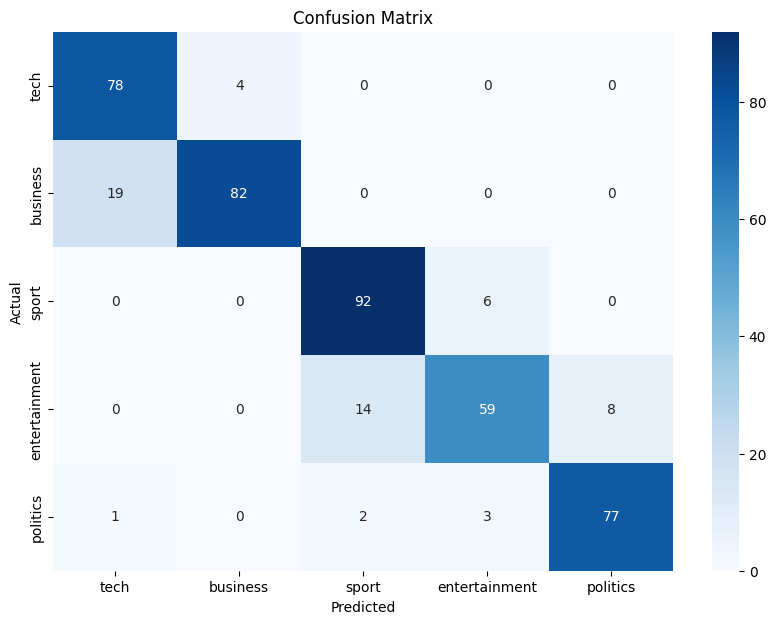

               precision    recall  f1-score   support

         tech       0.80      0.95      0.87        82
     business       0.95      0.81      0.88       101
        sport       0.85      0.94      0.89        98
entertainment       0.87      0.73      0.79        81
     politics       0.91      0.93      0.92        83

     accuracy                           0.87       445
    macro avg       0.87      0.87      0.87       445
 weighted avg       0.88      0.87      0.87       445



In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_id_df['category'], yticklabels=category_id_df['category'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=category_id_df['category']))

# **CNN-LeNet**

In [38]:
import tensorflow as tf
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 32 # Embedding layer size 128
max_length = 256  # Maximum sequence length

lenet = tf.keras.models.Sequential()
#Adding the embedding layer to convert input sequences to dense vectors of fixed size
lenet.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
# Convolutional layer for 1D input with 32 units with 'sigmoid' activation function, allows the network to identify important features in the text
lenet.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='sigmoid')) #input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))# Use Conv1D
#pooling layer that  further reduce the dimensionality of the features by taking the avarage value
lenet.add(tf.keras.layers.GlobalAveragePooling1D())
#flatten
lenet.add(tf.keras.layers.Flatten())
#full connection
lenet.add(tf.keras.layers.Dense(units=128, activation='sigmoid')) #number of hidden neurons
#output layer
lenet.add(tf.keras.layers.Dense(units=len(category_id_df), activation='softmax')) # Update to match the number of categories

# Compile the model using sparse_categorical_crossentropy for multi-class classification
lenet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lenet.summary()

#stop the Training of Neural Networks at the Right Time or Stop training when a monitored quantity has stopped improving
#monitor: quantity to be monitored;In min mode, training will stop when the quantity monitored has stopped decreasing; restore_best_weights:whether to restore model weights from the epoch with the best value of the monitored quantity.
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
#decreases the learning rate when the specified metric stops improving for longer than the patience number allows
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

import time
start_time = time.process_time()  # Record start time


# Train the CNN model
history_lenet=lenet.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=25,callbacks=[early_stopping, lr])

end_time = time.process_time()  # Record end time
print(f"Process Time: {end_time - start_time}")  # Calculate and print the difference

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2592 - loss: 1.6240 - val_accuracy: 0.2831 - val_loss: 1.5714 - learning_rate: 0.0010
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.2729 - loss: 1.5544 - val_accuracy: 0.5573 - val_loss: 1.4672 - learning_rate: 0.0010
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4912 - loss: 1.4294 - val_accuracy: 0.5933 - val_loss: 1.2800 - learning_rate: 0.0010
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6038 - loss: 1.2139 - val_accuracy: 0.6225 - val_loss: 1.0693 - learning_rate: 0.0010
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6663 - loss: 1.0063 - val_accuracy: 0.6899 - val_loss: 0.9003 - learning_rate: 0.0010
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6977 - loss: 0.8421 - val_accuracy: 0.7056 - val_loss: 0.7839 - learning_rate: 0.0010
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7155 - loss: 0.7271 - val_acc

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9413 - loss: 0.1854
Test Accuracy: 0.9461 Test Loss: 0.1821


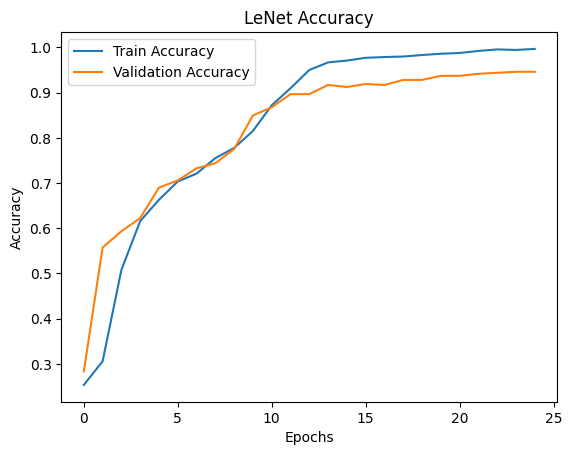

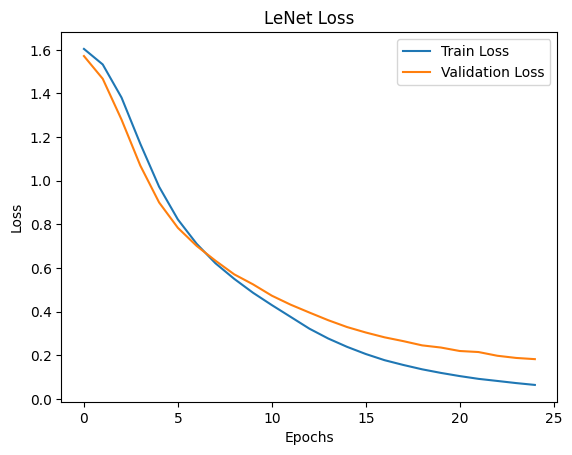

In [39]:
# Now evaluate the CNN model using X_test_cnn
loss, accuracy= lenet.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}",f"Test Loss: {loss:.4f}")

# Plot accuracy
plt.plot(history_lenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_lenet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LeNet Accuracy')
plt.show()

# Loss plot
plt.plot(history_lenet.history['loss'], label='Train Loss')
plt.plot(history_lenet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LeNet Loss')
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


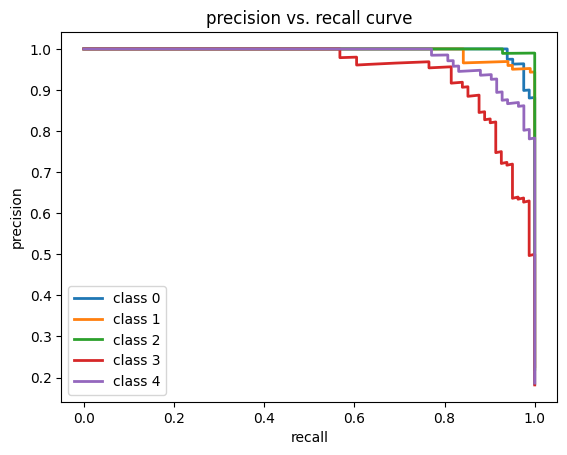

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np  # Import numpy for unique values


# precision recall curve
precision = dict()
recall = dict()

# Determine the number of unique classes
n_classes = len(np.unique(y_test))  # y_test contains the class labels

# Binarize the output - this creates a multi-label indicator array
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Assuming y_score contains the predicted probabilities for each class
y_score = lenet.predict(X_test)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


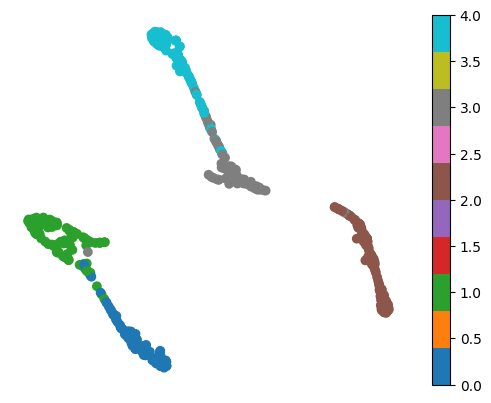

In [41]:
from sklearn.manifold import TSNE
X_valid_compressed=lenet.predict(X_test)
tsne = TSNE(n_components=2, random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_test, cmap="tab10")
plt.axis("off")
plt.colorbar()
plt.show()


# **CNN**-LeNet modefied

In [44]:
import tensorflow as tf
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 32 # Embedding layer size 128
max_length = 256  # Maximum sequence length

lenet2 = tf.keras.models.Sequential()

lenet2.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
# Convolutional layer for 1D input
#lenet2.add(tf.keras.layers.Conv1D(filters=128, kernel_size=11)) #95.73 0.1662
lenet2.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')) #92.58,96.18 0.1287input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))# Use Conv1D
#pooling
lenet2.add(tf.keras.layers.GlobalAveragePooling1D())

#flatten
lenet2.add(tf.keras.layers.Flatten())
#full connection
lenet2.add(tf.keras.layers.Dense(units=128, activation='relu')) #number of hidden neurons
#output layer
lenet2.add(tf.keras.layers.Dense(units=len(category_id_df), activation='softmax')) # Update to match the number of categories

# Compile the model using sparse_categorical_crossentropy for multi-class classification
lenet2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lenet2.summary()

start_time = time.process_time()  # Record start time

early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train the CNN model
history_lenet2=lenet2.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=10,callbacks=[early_stopping, lr])

end_time = time.process_time()  # Record end time
print(f"Process Time: {end_time - start_time}")  # Calculate and print the difference

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.2781 - loss: 1.5723 - val_accuracy: 0.5596 - val_loss: 1.3628 - learning_rate: 0.0010
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5868 - loss: 1.1682 - val_accuracy: 0.7730 - val_loss: 0.6271 - learning_rate: 0.0010
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8485 - loss: 0.4906 - val_accuracy: 0.9326 - val_loss: 0.3199 - learning_rate: 0.0010
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9621 - loss: 0.2004 - val_accuracy: 0.9573 - val_loss: 0.1587 - learning_rate: 0.0010
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9919 - loss: 0.0864 - val_accuracy: 0.9730 - val_loss: 0.1016 - learning_rate: 0.0010
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9990 - loss: 0.0397 - val_accuracy: 0.9798 - val_loss: 0.0803 - learning_rate: 0.0010
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9986 - loss: 0.0252 - val_acc

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9785 - loss: 0.0608
Test Accuracy: 0.9865 Test Loss: 0.0515


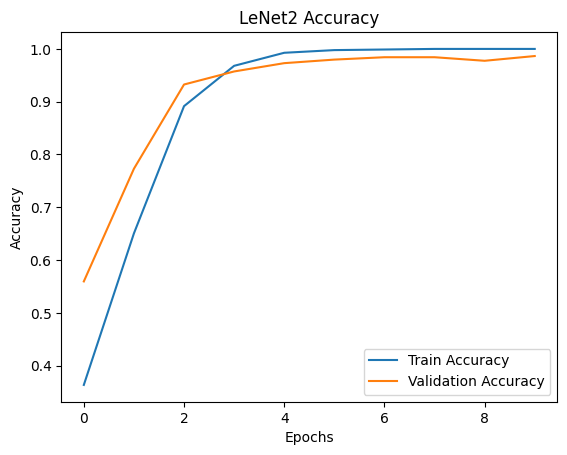

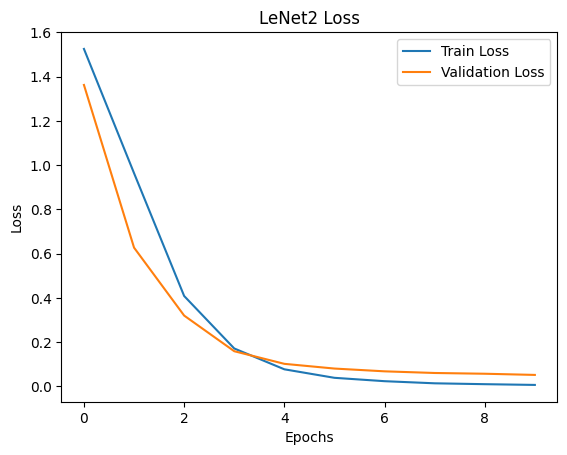

In [45]:
# Now evaluate the CNN model using X_test_cnn
loss, accuracy = lenet2.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}",f"Test Loss: {loss:.4f}")

# Plot accuracy
plt.plot(history_lenet2.history['accuracy'], label='Train Accuracy')
plt.plot(history_lenet2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LeNet2 Accuracy')
plt.show()

# Loss plot
plt.plot(history_lenet2.history['loss'], label='Train Loss')
plt.plot(history_lenet2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LeNet2 Loss')
plt.show()


In [46]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,f1_score
from sklearn.metrics import matthews_corrcoef

# Get predictions from your model (e.g., lenet2)
y_pred = np.argmax(lenet2.predict(X_test), axis=1)

pre_val=precision_score(y_true=y_test,y_pred=y_pred,average='weighted')
print(f'precision:{pre_val:.3f}')
rec_val=recall_score(y_true=y_test,y_pred=y_pred,average='weighted')
print(f'recall:{rec_val:.3f}')
f1_val=f1_score(y_true=y_test,y_pred=y_pred,average='weighted')
print(f'f1:{f1_val:.3f}')
mcc_val=matthews_corrcoef(y_true=y_test,y_pred=y_pred)
print(f'mcc:{mcc_val:.3f}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
precision:0.987
recall:0.987
f1:0.986
mcc:0.983


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


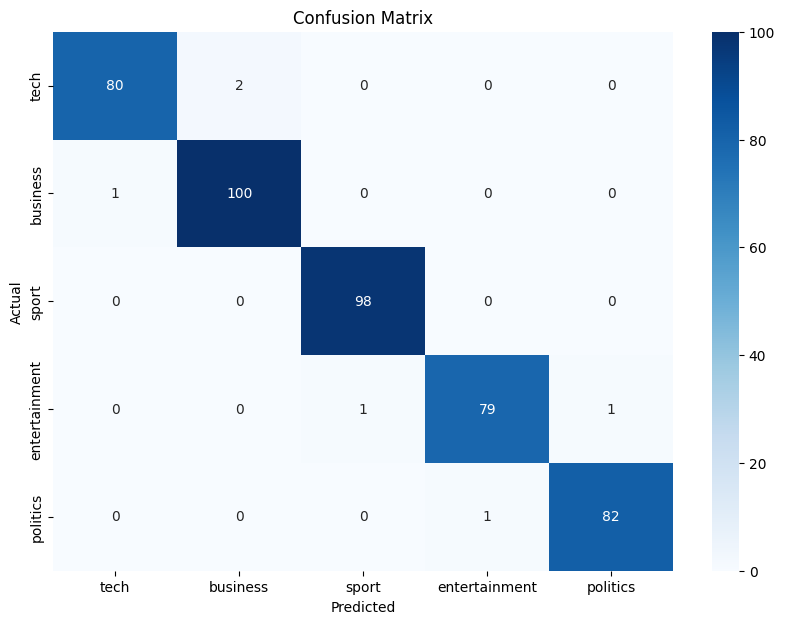

               precision    recall  f1-score   support

         tech       0.99      0.98      0.98        82
     business       0.98      0.99      0.99       101
        sport       0.99      1.00      0.99        98
entertainment       0.99      0.98      0.98        81
     politics       0.99      0.99      0.99        83

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99       445
 weighted avg       0.99      0.99      0.99       445



In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion Matrix
y_pred = np.argmax(lenet2.predict(X_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_id_df['category'], yticklabels=category_id_df['category'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LeNet2 Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=category_id_df['category']))


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


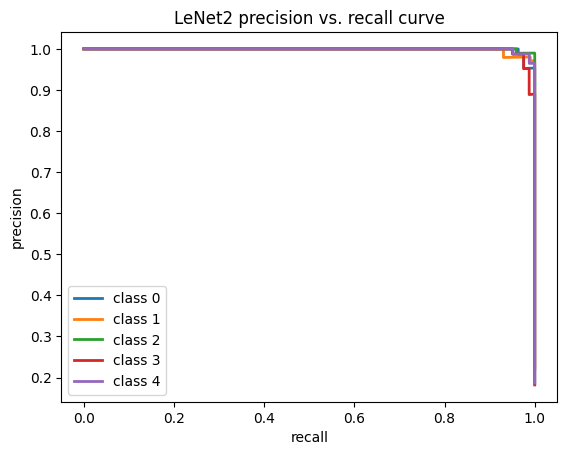

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np  # Import numpy for unique values


# precision recall curve
precision = dict()
recall = dict()

# Determine the number of unique classes
n_classes = len(np.unique(y_test))  # y_test contains the class labels
# Binarize the output - this creates a multi-label indicator array
y_test_bin = label_binarize(y_test, classes=range(n_classes))
# Assuming y_score contains the predicted probabilities for each class
y_score = lenet2.predict(X_test)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    #plt.plot(recall[i], precision[i], lw=2, label=category_id_df['category'])

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("LeNet2 precision vs. recall curve")
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


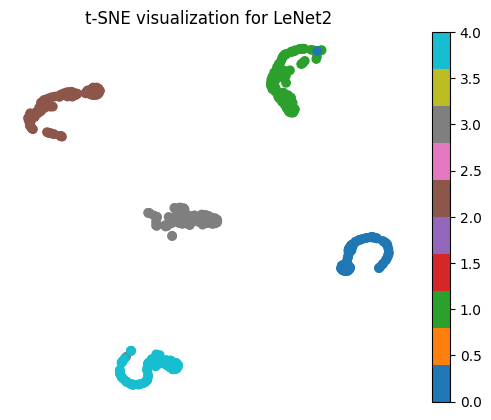

In [50]:
from sklearn.manifold import TSNE
X_valid_compressed=lenet2.predict(X_test)
tsne = TSNE(n_components=2, random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_test, cmap="tab10")
plt.axis("off")
plt.title('t-SNE visualization for LeNet2')
plt.colorbar()
plt.show()


# **CNN-AlexNet**

In [48]:
import tensorflow as tf
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 32 # Embedding layer size 128
max_length = 256  # Maximum sequence length

alexnet = tf.keras.models.Sequential()

alexnet.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
# Convolutional layer for 1D input
alexnet.add(tf.keras.layers.Conv1D(filters=96, kernel_size=11, strides=4, activation='relu'))
alexnet.add(tf.keras.layers.BatchNormalization())
alexnet.add(tf.keras.layers.MaxPool1D(pool_size=2))
alexnet.add(tf.keras.layers.Conv1D(filters=256, kernel_size=5, strides=2, activation='relu', padding="same"))
alexnet.add(tf.keras.layers.BatchNormalization())
alexnet.add(tf.keras.layers.MaxPool1D(pool_size=3))
alexnet.add(tf.keras.layers.Conv1D(filters=384, kernel_size=3, strides=1, activation='relu', padding="same"))
alexnet.add(tf.keras.layers.BatchNormalization())
alexnet.add(tf.keras.layers.Conv1D(filters=384, kernel_size=3, strides=1, activation='relu', padding="same"))
alexnet.add(tf.keras.layers.BatchNormalization())
alexnet.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, strides=1, activation='relu', padding="same"))
alexnet.add(tf.keras.layers.BatchNormalization())
alexnet.add(tf.keras.layers.MaxPool1D(pool_size=2))
alexnet.add(tf.keras.layers.Flatten())
alexnet.add(tf.keras.layers.Dense(4096,activation='relu'))
alexnet.add(tf.keras.layers.Dropout(0.5))
alexnet.add(tf.keras.layers.Dense(4096,activation='relu'))
alexnet.add(tf.keras.layers.Dropout(0.5))
alexnet.add(tf.keras.layers.Dense(units=len(category_id_df),activation='softmax'))

#alexnet.compile(loss='sparse_categorical_crossentropy',optimizer=tf.optimizers.SGD(lr=0.001),metrics=['accuracy'])

alexnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
alexnet.summary()

start_time = time.process_time()  # Record start time

# Train the CNN model
history_alexnet=alexnet.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=25,callbacks=[early_stopping, lr])

end_time = time.process_time()  # Record end time
print(f"Process Time: {end_time - start_time}")  # Calculate and print the difference


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │              

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 655ms/step - accuracy: 0.3021 - loss: 3.9636 - val_accuracy: 0.2202 - val_loss: 2.8320 - learning_rate: 0.0010
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 723ms/step - accuracy: 0.7171 - loss: 0.6968 - val_accuracy: 0.2202 - val_loss: 8.2461 - learning_rate: 0.0010
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 671ms/step - accuracy: 0.9066 - loss: 0.2584 - val_accuracy: 0.2202 - val_loss: 13.2460 - learning_rate: 0.0010
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 586ms/step - accuracy: 0.9803 - loss: 0.0685 - val_accuracy: 0.2202 - val_loss: 12.9674 - learning_rate: 5.0000e-04
Process Time: 213.81878512699768


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2093 - loss: 2.6637
Test Accuracy: 0.2202 Test Loss: 2.8320


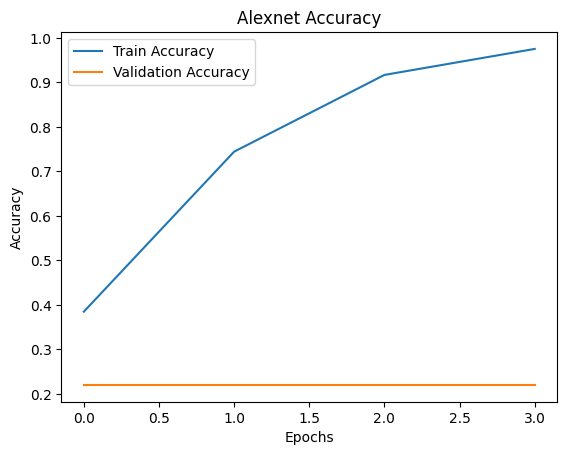

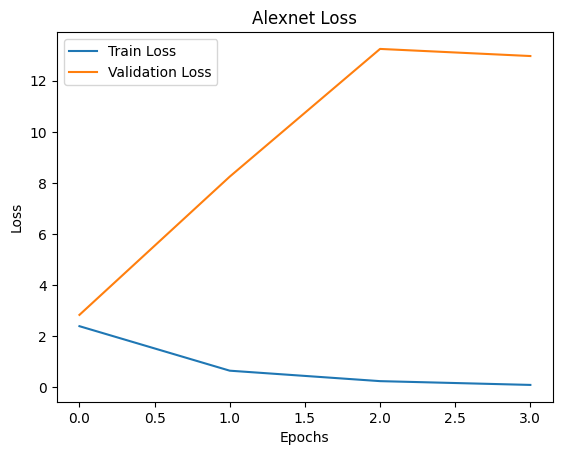

In [51]:
loss, accuracy = alexnet.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}",f"Test Loss: {loss:.4f}")
# Plot accuracy
plt.plot(history_alexnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_alexnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Alexnet Accuracy')
plt.show()

# Loss plot
plt.plot(history_alexnet.history['loss'], label='Train Loss')
plt.plot(history_alexnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Alexnet Loss')
plt.show()

In [53]:
import tensorflow as tf
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 32 # Embedding layer size 128
max_length = 256  # Maximum sequence length

alexnet2 = tf.keras.models.Sequential()

alexnet2.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
# Convolutional layer for 1D input
alexnet2.add(tf.keras.layers.Conv1D(filters=32, kernel_size=11, strides=4, activation='relu'))
alexnet2.add(tf.keras.layers.BatchNormalization())
alexnet2.add(tf.keras.layers.MaxPool1D(pool_size=2))
alexnet2.add(tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, activation='relu', padding="same"))
alexnet2.add(tf.keras.layers.BatchNormalization())
alexnet2.add(tf.keras.layers.MaxPool1D(pool_size=3))
alexnet2.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', padding="same"))
alexnet2.add(tf.keras.layers.BatchNormalization())
alexnet2.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, strides=1, activation='relu', padding="same"))
alexnet2.add(tf.keras.layers.BatchNormalization())
alexnet2.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, strides=1, activation='relu', padding="same"))
alexnet2.add(tf.keras.layers.BatchNormalization())
alexnet2.add(tf.keras.layers.MaxPool1D(pool_size=2))
alexnet2.add(tf.keras.layers.Flatten())
alexnet2.add(tf.keras.layers.Dense(128,activation='relu'))
alexnet2.add(tf.keras.layers.Dropout(0.5))
alexnet2.add(tf.keras.layers.Dense(128,activation='relu'))
alexnet2.add(tf.keras.layers.Dropout(0.5))
alexnet2.add(tf.keras.layers.Dense(units=len(category_id_df),activation='softmax'))

#alexnet.compile(loss='sparse_categorical_crossentropy',optimizer=tf.optimizers.SGD(lr=0.001),metrics=['accuracy'])

alexnet2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
alexnet2.summary()
# Train the CNN model
history_alexnet2=alexnet2.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=15,callbacks=[early_stopping, lr])


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │              

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.1892 - loss: 2.1453 - val_accuracy: 0.2202 - val_loss: 1.6087 - learning_rate: 0.0010
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2809 - loss: 1.6414 - val_accuracy: 0.2270 - val_loss: 1.6026 - learning_rate: 0.0010
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3754 - loss: 1.4329 - val_accuracy: 0.2337 - val_loss: 1.5980 - learning_rate: 0.0010
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4522 - loss: 1.3527 - val_accuracy: 0.2270 - val_loss: 1.6183 - learning_rate: 0.0010
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5831 - loss: 1.0818 - val_accuracy: 0.2202 - val_loss: 1.8552 - learning_rate: 0.0010
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7101 - loss: 0.7285 - val_accuracy: 0.2225 - val_loss: 2.0387 - learning_rate: 5.0000e-04


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1975 - loss: 1.5961
Test Accuracy: 0.2337 Test Loss: 1.5980


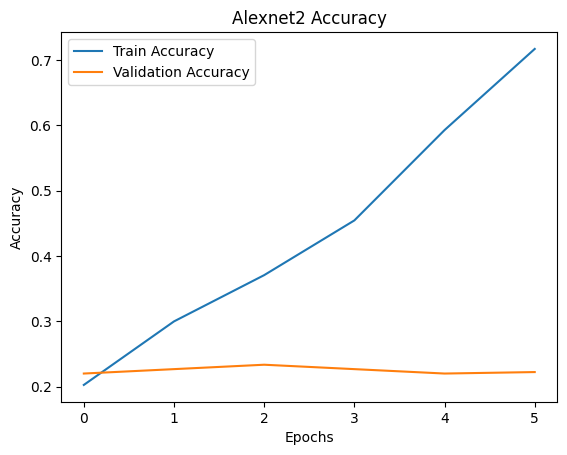

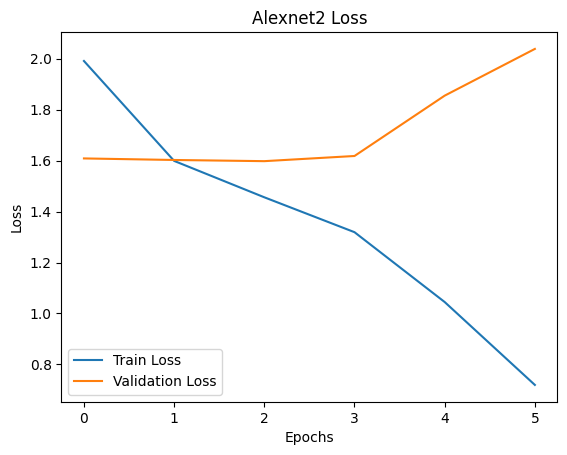

In [54]:
loss, accuracy = alexnet2.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}",f"Test Loss: {loss:.4f}")
# Plot accuracy
plt.plot(history_alexnet2.history['accuracy'], label='Train Accuracy')
plt.plot(history_alexnet2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Alexnet2 Accuracy')
plt.show()

# Loss plot
plt.plot(history_alexnet2.history['loss'], label='Train Loss')
plt.plot(history_alexnet2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Alexnet2 Loss')
plt.show()


# **CNN-VGG**

In [56]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
import numpy as np
import tensorflow as tf

vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 32 # Embedding layer size 128
max_length = 256  # Maximum sequence length

vgg = tf.keras.models.Sequential()
vgg.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
vgg.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))

vgg.add(tf.keras.layers.Conv1D(filters=64,kernel_size=3,padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2))

vgg.add(Flatten())
vgg.add(Dense(units=4096,activation="relu"))
vgg.add(Dense(units=4096,activation="relu"))
vgg.add(Dense(units=5, activation="softmax"))

#vgg.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg.summary()
# Train the CNN model
#checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#hist = model.fit_generator(steps_per_epoch=100,generator=traindata, validation_data= testdata, validation_steps=10,epochs=100,callbacks=[checkpoint,early])
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history_vgg=vgg.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=25,callbacks=[early_stopping, lr])

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_32 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_33 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_34 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_35 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_36 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_37 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_38 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_39 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_40 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_41 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_42 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_43 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_44 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.2274 - loss: 1.6095 - val_accuracy: 0.2270 - val_loss: 1.6050 - learning_rate: 0.0010
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.2426 - loss: 1.5997 - val_accuracy: 0.2202 - val_loss: 1.6055 - learning_rate: 0.0010
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.2262 - loss: 1.6053 - val_accuracy: 0.2202 - val_loss: 1.6052 - learning_rate: 0.0010
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.2225 - loss: 1.6050 - val_accuracy: 0.2202 - val_loss: 1.6056 - learning_rate: 5.0000e-04


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - accuracy: 0.2026 - loss: 1.6114
Test Accuracy: 0.2270 Test Loss: 1.6050


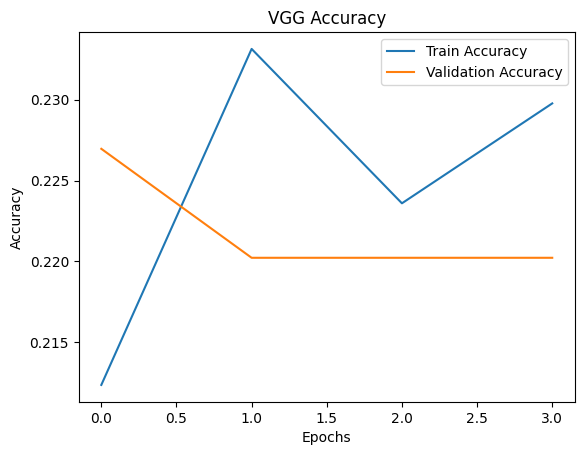

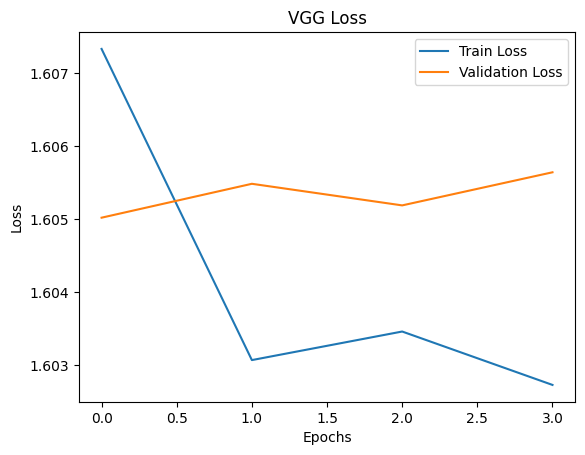

In [57]:
loss, accuracy = vgg.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}",f"Test Loss: {loss:.4f}")
# Plot accuracy
plt.plot(history_vgg.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('VGG Accuracy')
plt.show()

# Loss plot
plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('VGG Loss')
plt.show()

# **Evaluation**

In [58]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,f1_score

# Get predictions and f1 from the model
#y_pred = np.argmax(lenet2.predict(X_test), axis=1)
#f1_val=f1_score(y_true=y_test,y_pred=y_pred,average='weighted')
#print(f'f1:{f1_val:.3f}')

# Evaluate the model
RNN_loss, RNN_accuracy = RNN_model.evaluate(X_test, y_test)
print(f"RNN Test Accuracy: {RNN_accuracy}")
print(f"RNN Test loss: {RNN_loss}")
y_pred_rnn = np.argmax(RNN_model.predict(X_test), axis=1)
f1_rnn=f1_score(y_true=y_test,y_pred=y_pred_rnn,average='weighted')
print(f'RNN f1:{f1_rnn:.3f}')


GRU_loss, GRU_accuracy = GRU_model.evaluate(X_test, y_test)
print(f"GRU Test Accuracy: {GRU_accuracy}")
print(f"GRU RNN Test loss: {GRU_loss}")
y_pred_gru = np.argmax(GRU_model.predict(X_test), axis=1)
f1_gru=f1_score(y_true=y_test,y_pred=y_pred_gru,average='weighted')
print(f'GRU f1:{f1_gru:.3f}')

lenet2_loss, lenet2_accuracy = lenet2.evaluate(X_test, y_test)
print(f"LeNet2 Test Accuracy: {lenet2_accuracy}")
print(f"LeNet2 Test loss: {lenet2_loss}")
y_pred_lenet2 = np.argmax(lenet2.predict(X_test), axis=1)
f1_lenet2=f1_score(y_true=y_test,y_pred=y_pred_lenet2,average='weighted')
print(f'LeNet2 f1:{f1_lenet2:.3f}')

lstm_loss, lstm_accuracy = model.evaluate(X_test, y_test)
print(f"lstm Test Accuracy: {lstm_accuracy}")
print(f"lstm Test loss: {lstm_loss}")
y_pred_lstm = np.argmax(model.predict(X_test), axis=1)
f1_lstm=f1_score(y_true=y_test,y_pred=y_pred_lstm,average='weighted')
print(f'Lstm f1:{f1_rnn:.3f}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9526 - loss: 0.2013
RNN Test Accuracy: 0.9415730237960815
RNN Test loss: 0.2294883280992508
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step
RNN f1:0.942
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9869 - loss: 0.1342
GRU Test Accuracy: 0.9887640476226807
GRU RNN Test loss: 0.11535034328699112
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step
GRU f1:0.989
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9785 - loss: 0.0608
LeNet2 Test Accuracy: 0.9865168333053589
LeNet2 Test loss: 0.05152047425508499
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LeNet2 f1:0.986
14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8917 - loss: 0.3081
lstm Test Accuracy: 0.8719100952148438
lstm Test loss: 0.3419111967086792
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
Lstm f1:0.942


In [60]:
from tensorflow.keras.models import load_model

# New real-world data
new_data = [
    "Trump says US will impose additional 10% tariff on China",
    "WhatsApp says it has resolved technical problem.",
    "South Africa thrash England to reach semis - reaction",
    "Brit Awards: Five things to look out for in tonight's ceremony.",
    "Starmer wins Trump over - but Ukraine uncertainty lingers"
]

# Preprocess new data
new_data_processed = [prioritize_features(text, top_features_named) for text in new_data]
new_sequences = tokenizer.texts_to_sequences(new_data_processed)
new_padded_sequences = pad_sequences(new_sequences, maxlen=500)

# Ensure input type matches the model requirements
new_padded_sequences = np.array(new_padded_sequences, dtype=np.int32)  # Ensure dtype compatibility

# Make predictions
try:
    new_predictions = GRU_model.predict(new_padded_sequences)
    predicted_categories = [category_id_df['category'][np.argmax(pred)] for pred in new_predictions]

    # Display predictions
    for i, text in enumerate(new_data):
        print(f"Text: {text}")
        print(f"Predicted Category: {predicted_categories[i]}")
        print("-" * 50)
except Exception as e:
    print(f"Error: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Text: Trump says US will impose additional 10% tariff on China
Predicted Category: entertainment
--------------------------------------------------
Text: WhatsApp says it has resolved technical problem.
Predicted Category: entertainment
--------------------------------------------------
Text: South Africa thrash England to reach semis - reaction
Predicted Category: business
--------------------------------------------------
Text: Brit Awards: Five things to look out for in tonight's ceremony.
Predicted Category: entertainment
--------------------------------------------------
Text: Starmer wins Trump over - but Ukraine uncertainty lingers
Predicted Category: entertainment
--------------------------------------------------


In [61]:
# Real-world data testing
new_data = [
    "AI is transforming the tech industry.",
    "The stock market saw significant growth today.",
    "The team secured a dramatic win in the championship final.",
    "This movie is one of the best I've seen in years.",
    "The government announced new environmental policies.",
    "Exclusive: Senators ask Trump's Air Force nominee to respond to allegations of favoring Musk's SpaceX"

]

# Preprocess real-world data
def preprocess_real_world_data(data, tokenizer, top_features_named, maxlen=500):
    data = [prioritize_features(text, top_features_named) for text in data]  # Apply feature prioritization
    sequences = tokenizer.texts_to_sequences(data)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)
    return padded_sequences # Added proper indentation

new_data_processed = preprocess_real_world_data(new_data, tokenizer, top_features_named)

# Predict categories
predictions = RNN_model.predict(new_data_processed)
predicted_categories = [category_id_df['category'][np.argmax(pred)] for pred in predictions]

# Display predictions
print("Predictions for Real-World Data:")
for i, text in enumerate(new_data):
    print(f"Text: {text}")
    print(f"Predicted Category: {predicted_categories[i]}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Predictions for Real-World Data:
Text: AI is transforming the tech industry.
Predicted Category: sport
--------------------------------------------------
Text: The stock market saw significant growth today.
Predicted Category: sport
--------------------------------------------------
Text: The team secured a dramatic win in the championship final.
Predicted Category: sport
--------------------------------------------------
Text: This movie is one of the best I've seen in years.
Predicted Category: entertainment
--------------------------------------------------
Text: The government announced new environmental policies.
Predicted Category: sport
--------------------------------------------------
Text: Exclusive: Senators ask Trump's Air Force nominee to respond to allegations of favoring Musk's SpaceX
Predicted Category: sport
--------------------------------------------------
